# Melbourne Housing Market - Exploratory Data Analysis (EDA)
## Introduction
This notebook presents a comprehensive Exploratory Data Analysis (EDA) of the Melbourne Housing Snapshot dataset. The goal is to understand the underlying patterns in the local real estate market, identify key factors influencing property prices, and prepare the data for the machine learning pipeline used in our Recommender System.

## Objectives
In this analysis, we will focus on the following steps:

- Data Cleaning: Handling missing values, duplicates, and correcting data types to ensure quality.

- Feature Analysis: Understanding the distribution of key variables such as Price, Rooms, and Regionname.

- Correlation Analysis: Identifying relationships between different features (e.g., how Rooms or Landsize correlate with Price).

- Geospatial Visualization: Mapping properties to visualize price hotspots across Melbourne.

## The Dataset
The dataset `melb_data.csv` contains snapshots of housing data including:

Location & Address:

- **Suburb**: Suburb of the property.

- **Address**: Exact address.

- **Postcode**: Postal code.

- **CouncilArea**: Governing council for the area.

- **Regionname**: General region within Melbourne (e.g., Southern Metropolitan).

- **Lattitude**: Geographical latitude.

- **Longtitude**: Geographical longitude.

Property Characteristics:

- **Rooms**: Number of rooms.

- **Type**: Property type (h = house, u = unit, t = townhouse).

- **Bedroom2**: Scraped number of bedrooms (from a different source).

- **Bathroom**: Number of bathrooms.

- **Car**: Number of car spots.

- **Landsize**: Land size in square meters.

- **BuildingArea**: Building size in square meters.

- **YearBuilt**: Year the house was built.

Market & Sales Data:

- **Price**: The selling price (Target Variable).

- **Method**: Method of sale. Key values include:

    - `S`: Property sold.
    - `SP`: Property sold prior to auction.
    - `PI`: Property passed in (bid did not reach reserve price).
    - `VB`: Vendor bid (bid made by the seller to keep auction going).
    - `SA`: Sold after auction.
    - `SN`: Sold not disclosed.

- **SellerG**: Real Estate Agent.

- **Date**: Date of sale.

- **Distance**: Distance from the Central Business District (CBD).

- **Propertycount**: Number of properties that exist in the suburb (density indicator).

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# Load dataset
df = pd.read_csv('melb_data.csv')

print("Dataset dimensions:", df.shape)
display(df.head())

Dataset dimensions: (13580, 21)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [48]:
print("\nDataset infos:")
print(df.info())


Dataset infos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  flo

## Data Cleaning and Preprocessing
From the `df.info()` summary above, we can identify a few critical issues that need addressing before analysis:

**1. Missing Values:**
* **BuildingArea** & **YearBuilt:** Filled using the **median of the specific Suburb**. Houses in the same suburb often share similar characteristics and construction eras.
* **Car:** A small number of missing values. We will assume missing means 0 car spots.
* **CouncilArea:** Some missing values. We will fill these with the mode of the specific Suburb.

**2. Data Types:**
* Converting floating-point numbers into Integers for better readability.
* **Date:** Currently stored as an `object` (string). We need to convert this to a `datetime` object to extract useful features like Year or Month later.


#### Action: Handling Missing Data and Converting Types
We will now apply these transformations to create a clean dataset.

In [49]:
# Helper function to fill missing values with the group's median (Neighborhood context)
def fill_with_suburb_median(df, target_col, group_col='Suburb'):
    # Calculate the median for each suburb and fill the holes
    df[target_col] = df[target_col].fillna(df.groupby(group_col)[target_col].transform('median'))
    # Fallback: If a suburb is entirely empty, fill remaining holes with the global median
    df[target_col] = df[target_col].fillna(df[target_col].median())
    return df

# Apply to BuildingArea and YearBuilt
df = fill_with_suburb_median(df, 'BuildingArea')
df = fill_with_suburb_median(df, 'YearBuilt')

# Apply to Car
# We assume NaN means 0 parking spots
df['Car'] = df['Car'].fillna(0)

# For CouncilArea (Categorical), we use the Mode of the suburb
df['CouncilArea'] = df.groupby('Suburb')['CouncilArea'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown")
)
# Final Fallback for CouncilArea (if any holes remain)
df['CouncilArea'] = df['CouncilArea'].fillna(df['CouncilArea'].mode()[0])


# --- Data Type Conversion and Formatting ---

# Date Conversion
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Conversion to integers
# Round first for safety, then convert to int
cols_to_int = ['Rooms', 'Bathroom', 'Car', 'Bedroom2', 'YearBuilt', 'Propertycount']

for col in cols_to_int:
    df[col] = df[col].round().astype(int)

# --- Final Verification ---
print(f"Total remaining missing values: {df.isnull().sum().sum()}")

Total remaining missing values: 0


## Target Variable Analysis (Price)
The primary goal of this project is to understand and predict housing prices. We start by analyzing the distribution of the `Price` column.

**Objectives:**
1. Visualize the distribution using a Histogram and Kernel Density Estimate (KDE).
2. Calculate key statistics (Mean, Median, Standard Deviation).
3. Check for **skewness**: In real estate, prices are often "right-skewed" (a long tail of expensive properties).


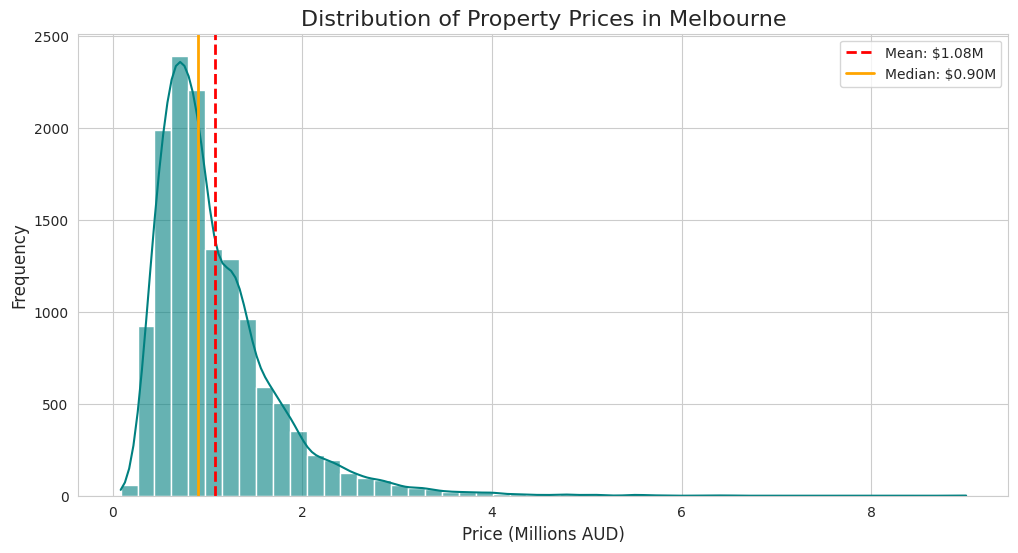

Price Statistics (AUD):
count       13,580.00
mean     1,075,684.08
std        639,310.72
min         85,000.00
25%        650,000.00
50%        903,000.00
75%      1,330,000.00
max      9,000,000.00
Name: Price, dtype: object


In [50]:
plt.figure(figsize=(12, 6))

# Histogram with KDE (Kernel Density Estimate)
# Divided by 1,000,000 to make the X-axis more readable (Millions)
sns.histplot(df['Price'] / 1_000_000, kde=True, bins=50, color='teal', alpha=0.6)

# Add vertical lines for Mean and Median
mean_price = df['Price'].mean() / 1_000_000
median_price = df['Price'].median() / 1_000_000

plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_price:,.2f}M')
plt.axvline(median_price, color='orange', linestyle='-', linewidth=2, label=f'Median: ${median_price:,.2f}M')

# Labels and Title
plt.title('Distribution of Property Prices in Melbourne', fontsize=16)
plt.xlabel('Price (Millions AUD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

plt.show()

# Print detailed statistics
print("Price Statistics (AUD):")
print(df['Price'].describe().apply(lambda x: format(x, ',.2f')))

**Observations on Price Distribution:**
* **Right-Skewed Distribution:** The graph shows a clear positive skew (long tail to the right). This is typical for real estate markets: the majority of properties are clustered around the median price, while a small number of luxury properties with very high prices pull the curve to the right.
* **Mean vs Median:** The Mean (Red line) is higher than the Median (Orange line), confirming the skewness. For this reason, the **Median** is often a more robust metric to describe the "typical" house price in Melbourne.

## Univariate Analysis of Features
To fully understand our dataset, we examine the distribution of the independent variables. We split them into **Categorical/Discrete** (counts) and **Continuous** (measurements) to use appropriate visualization techniques.

###  Categorical & Discrete Variables
We analyze the frequency of listings based on:
* **Property Characteristics:** `Type`, `Rooms`, `Bathroom`, `Car`.
* **Location:** `Regionname`.
* **Sales Info:** `Method`, `SellerG` (Real Estate Agents).

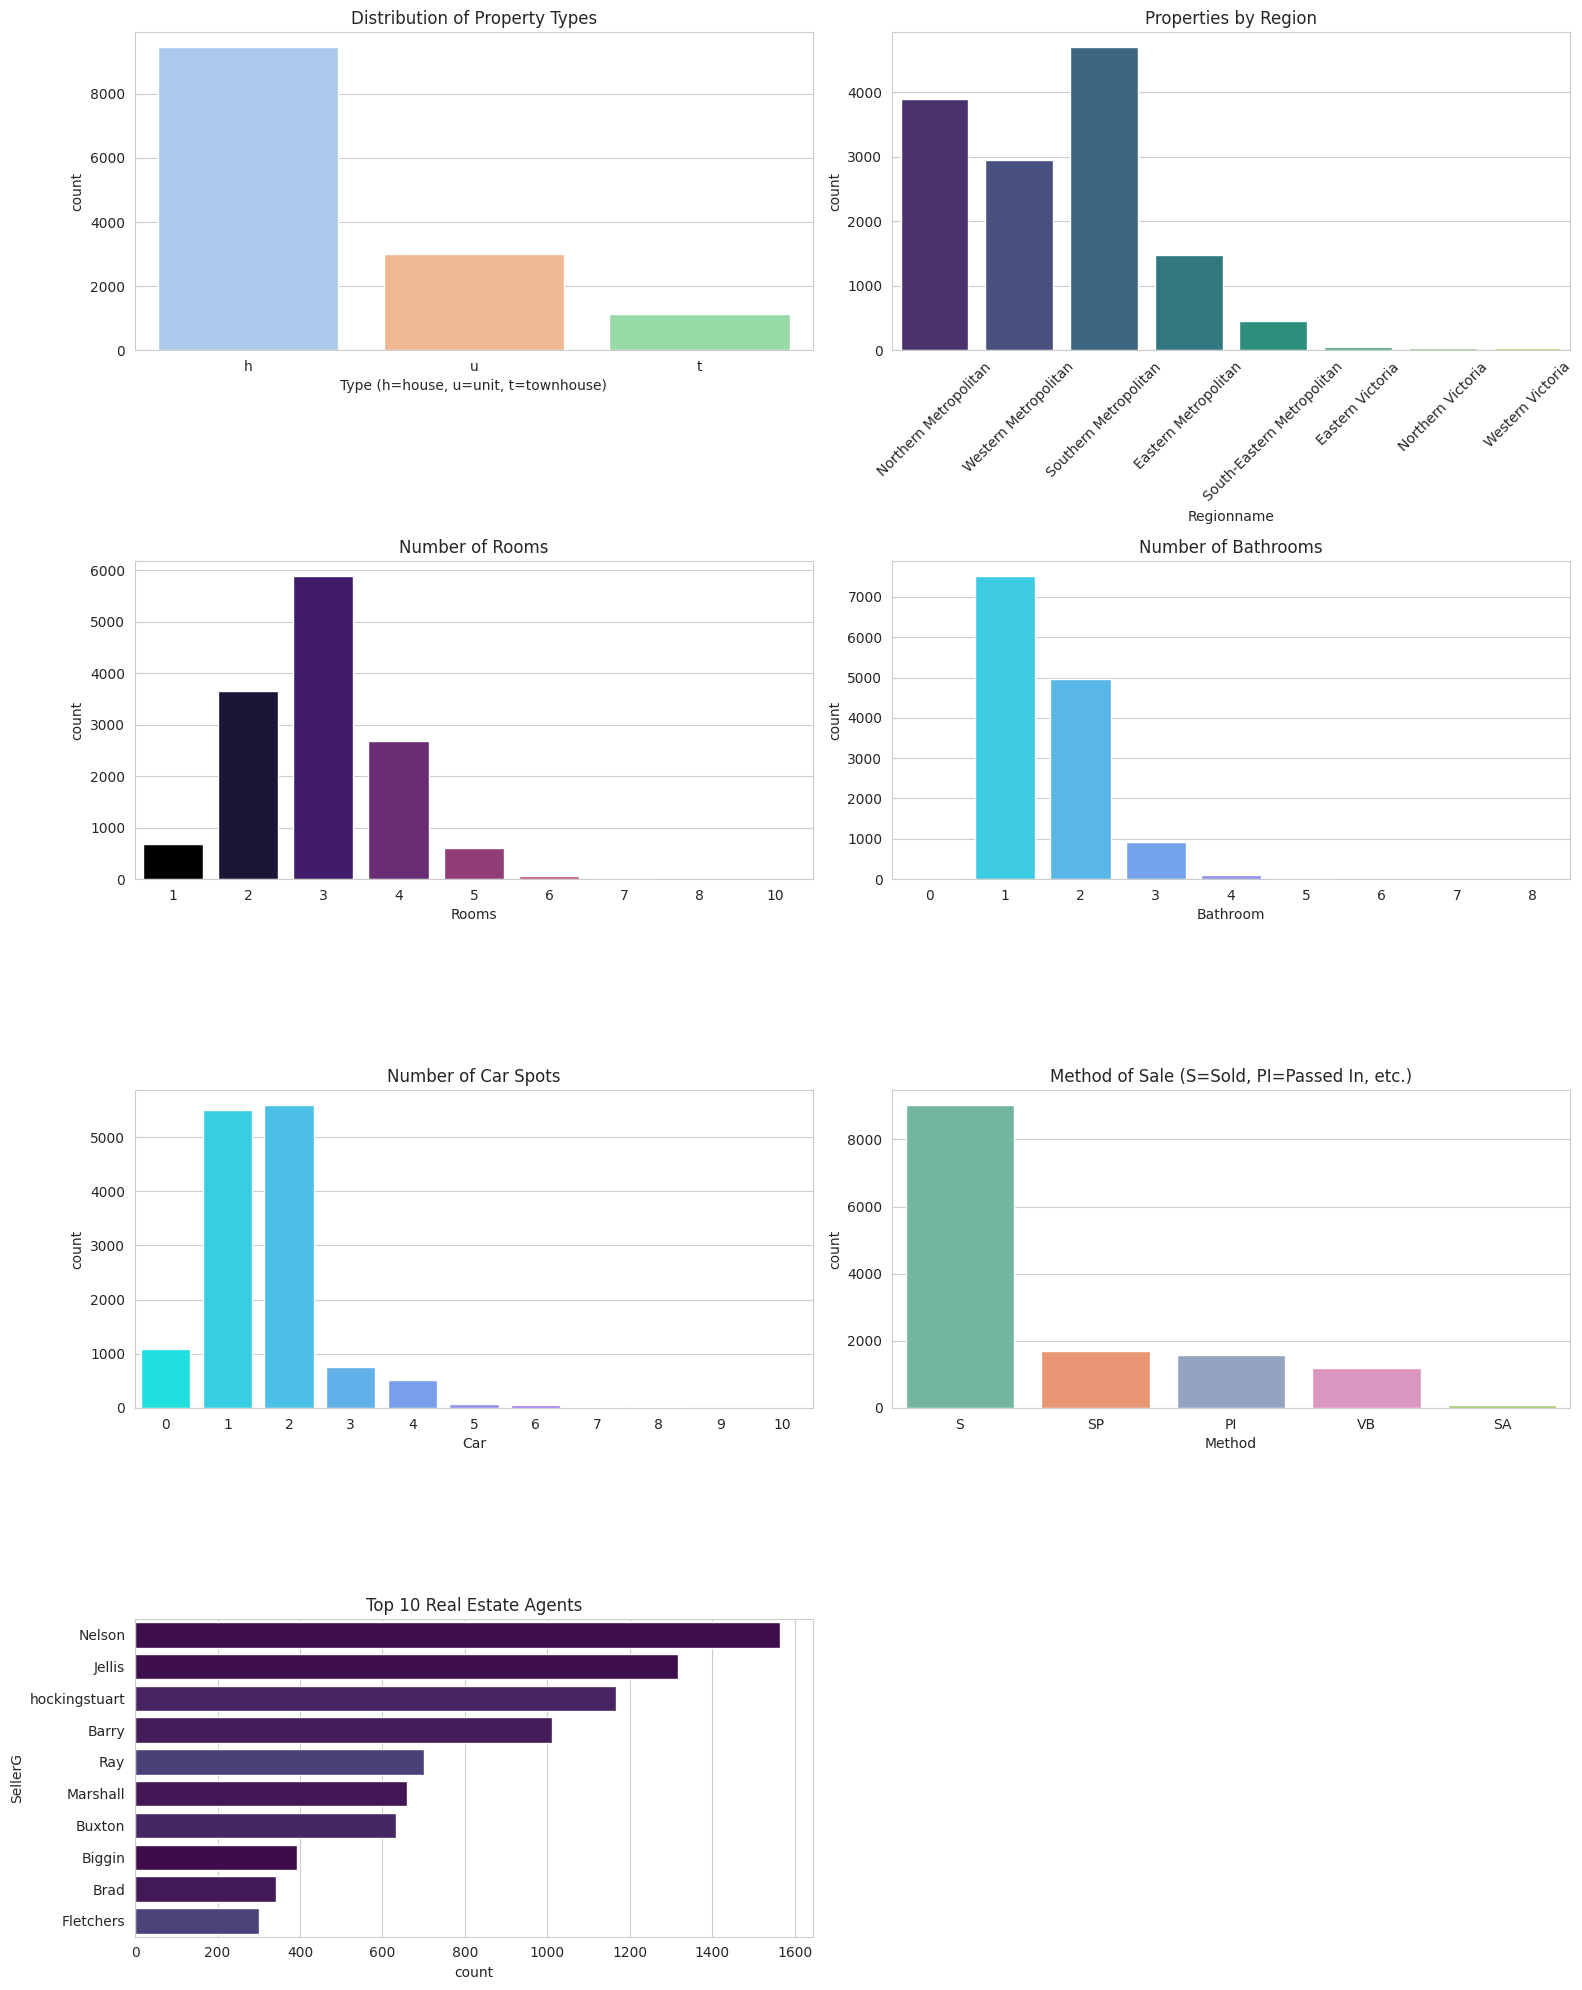

In [51]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))

# Type of Property
sns.countplot(data=df, x='Type', hue='Type', palette='pastel', legend=False, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Property Types')
axes[0, 0].set_xlabel('Type (h=house, u=unit, t=townhouse)')

# Region Name (Location)
sns.countplot(data=df, x='Regionname', hue='Regionname', palette='viridis', legend=False, ax=axes[0, 1])
axes[0, 1].set_title('Properties by Region')
axes[0, 1].tick_params(axis='x', rotation=45)

# Rooms (Discrete)
sns.countplot(data=df, x='Rooms', hue='Rooms', palette='magma', legend=False, ax=axes[1, 0])
axes[1, 0].set_title('Number of Rooms')

# Bathrooms (Discrete)
sns.countplot(data=df, x='Bathroom', hue='Bathroom', palette='cool', legend=False, ax=axes[1, 1])
axes[1, 1].set_title('Number of Bathrooms')

# Car Spots (Discrete)
sns.countplot(data=df, x='Car', hue='Car', palette='cool', legend=False, ax=axes[2, 0])
axes[2, 0].set_title('Number of Car Spots')

# Method of Sale
sns.countplot(data=df, x='Method', hue='Method', palette='Set2', legend=False, ax=axes[2, 1])
axes[2, 1].set_title('Method of Sale (S=Sold, PI=Passed In, etc.)')

# Top 10 Sellers (Agents)
top_sellers = df['SellerG'].value_counts().head(10).index
sns.countplot(data=df, y='SellerG', hue='SellerG', palette='viridis', legend=False, order=top_sellers, ax=axes[3, 0])
axes[3, 0].set_title('Top 10 Real Estate Agents')


fig.delaxes(axes[3, 1])

plt.tight_layout()
plt.show()

**Key Observations:**
* **Type:** The majority of listings are Houses (`h`), followed by Units (`u`). Townhouses (`t`) are the minority.
* **Location:** The "Southern Metropolitan" and "Northern Metropolitan" regions have the highest number of listings.
* **Structure:** The typical property has **3 Rooms**, **1 Bathroom**, and **1-2 Car spots**.
* **Agents:** `Nelson` and `Jellis` are the dominant real estate agencies in this dataset.

### Continuous Variables
Here we analyze the distribution of measurements.
* **Distance:** Distance from the Central Business District (CBD).
* **YearBuilt:** Construction year.
* **Landsize & BuildingArea:** Area in square meters.

*Note: For `Landsize` and `BuildingArea`, we apply a temporary filter (zoom) to exclude extreme outliers (e.g., large estates) and visualize the main distribution clearly.*

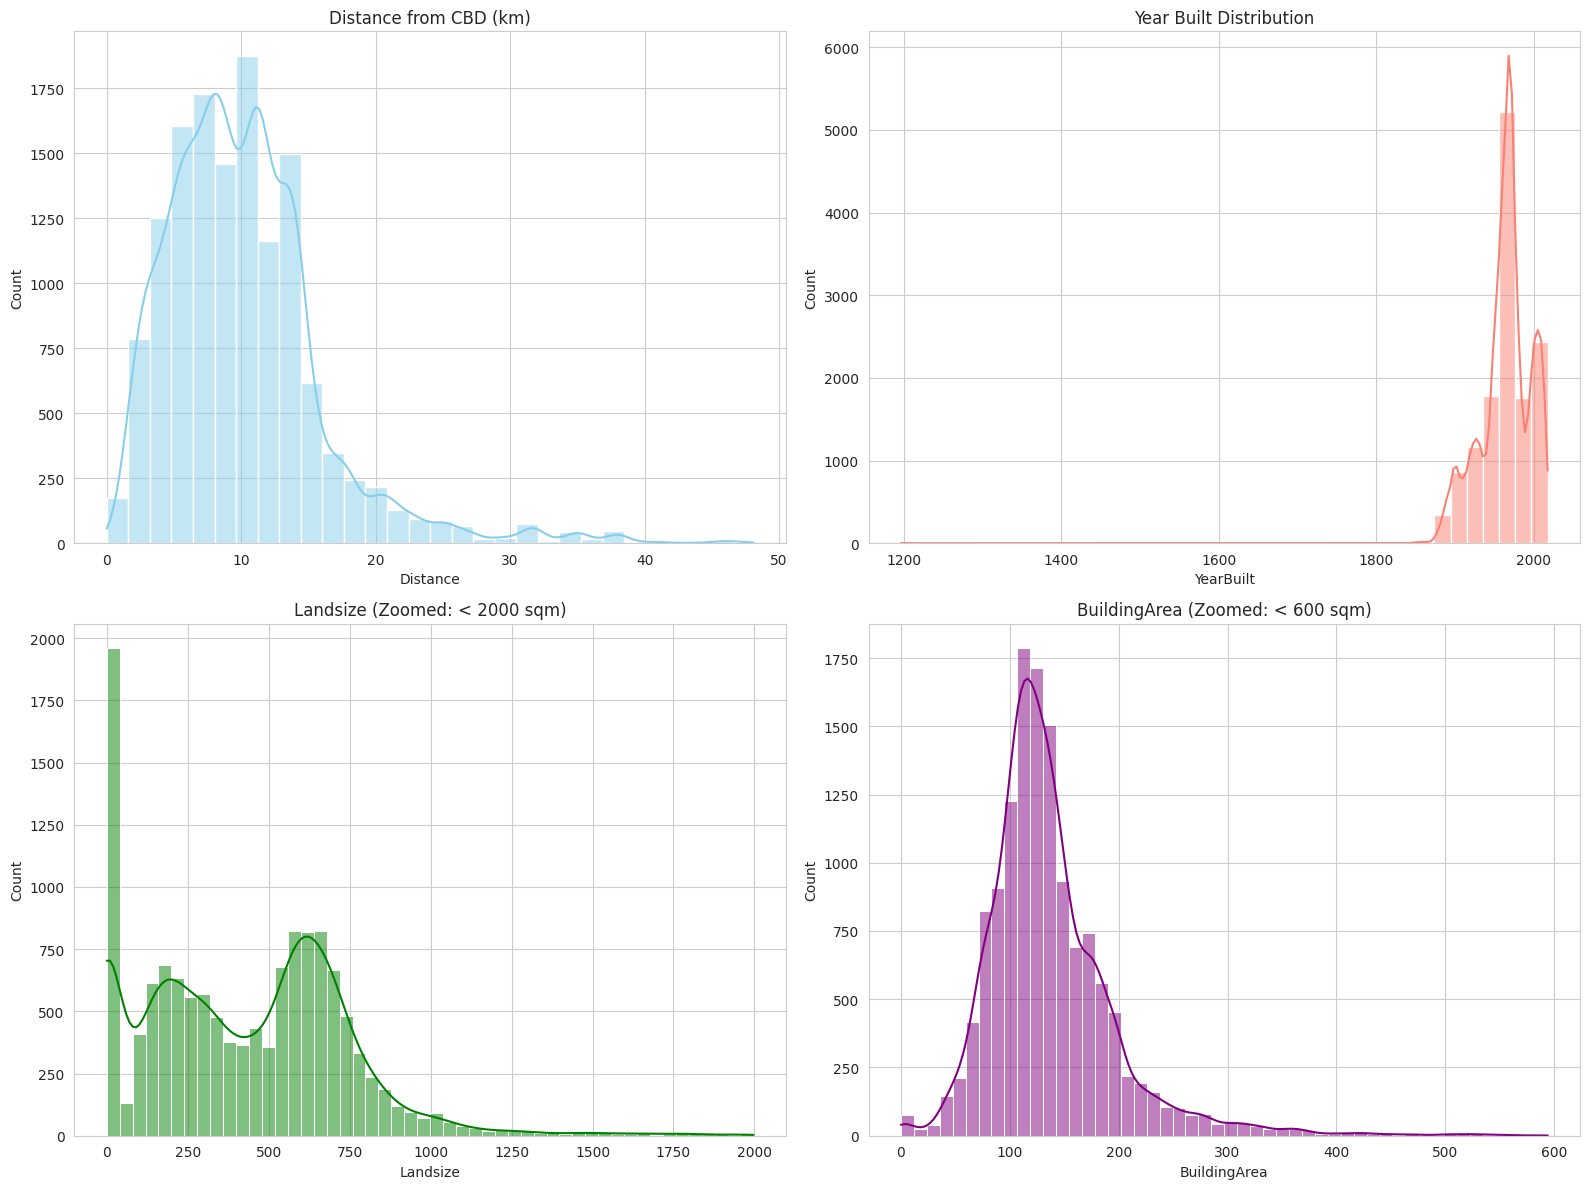

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distance from CBD
sns.histplot(df['Distance'], bins=30, kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distance from CBD (km)')

# Year Built
sns.histplot(df['YearBuilt'], bins=40, kde=True, color='salmon', ax=axes[0, 1])
axes[0, 1].set_title('Year Built Distribution')

# Landsize (Zoomed View < 2000 sqm)
sns.histplot(df[df['Landsize'] < 2000]['Landsize'], bins=50, kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_title('Landsize (Zoomed: < 2000 sqm)')

# BuildingArea (Zoomed View < 600 sqm)
sns.histplot(df[df['BuildingArea'] < 600]['BuildingArea'], bins=50, kde=True, color='purple', ax=axes[1, 1])
axes[1, 1].set_title('BuildingArea (Zoomed: < 600 sqm)')

plt.tight_layout()
plt.show()

**Key Observations:**
* **Distance:** Most properties are located between **5km and 15km** from the CBD.
* **Age:** There is a mix of historic homes (late 1800s/early 1900s) and a boom of modern constructions from the 1990s onwards.
* **Size:** The distribution of `BuildingArea` is centered around 100-200 sqm, which aligns with the typical 3-bedroom configuration seen earlier.

### Data Quality Check: Redundancy
We omitted high-cardinality variables like `Address` and `Suburb` from the plots above.
We also need to verify the `Bedroom2` feature, which is often a scraped duplicate of `Rooms`.

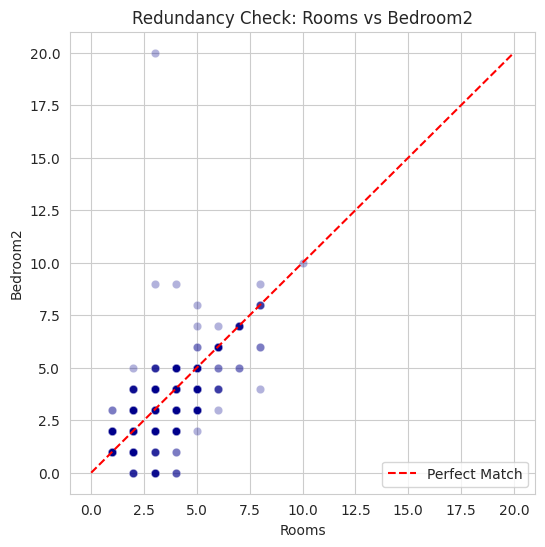

Correlation: 0.9442


In [53]:
# Scatterplot to check correlation between Rooms and Bedroom2
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df['Rooms'], y=df['Bedroom2'], alpha=0.3, color='darkblue')

# Identity line
max_val = max(df['Rooms'].max(), df['Bedroom2'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Match')

plt.title('Redundancy Check: Rooms vs Bedroom2')
plt.legend()
plt.show()

print(f"Correlation: {df['Rooms'].corr(df['Bedroom2']):.4f}")

**Conclusion:**
The correlation is extremely high (near 1.0) and the points mostly lie on the diagonal. **`Bedroom2` provides redundant information** and can likely be dropped in favor of `Rooms` during feature selection.

## Correlation Analysis
Finally, we compute the Pearson Correlation Coefficient to identify which numeric features are the strongest predictors of `Price`.

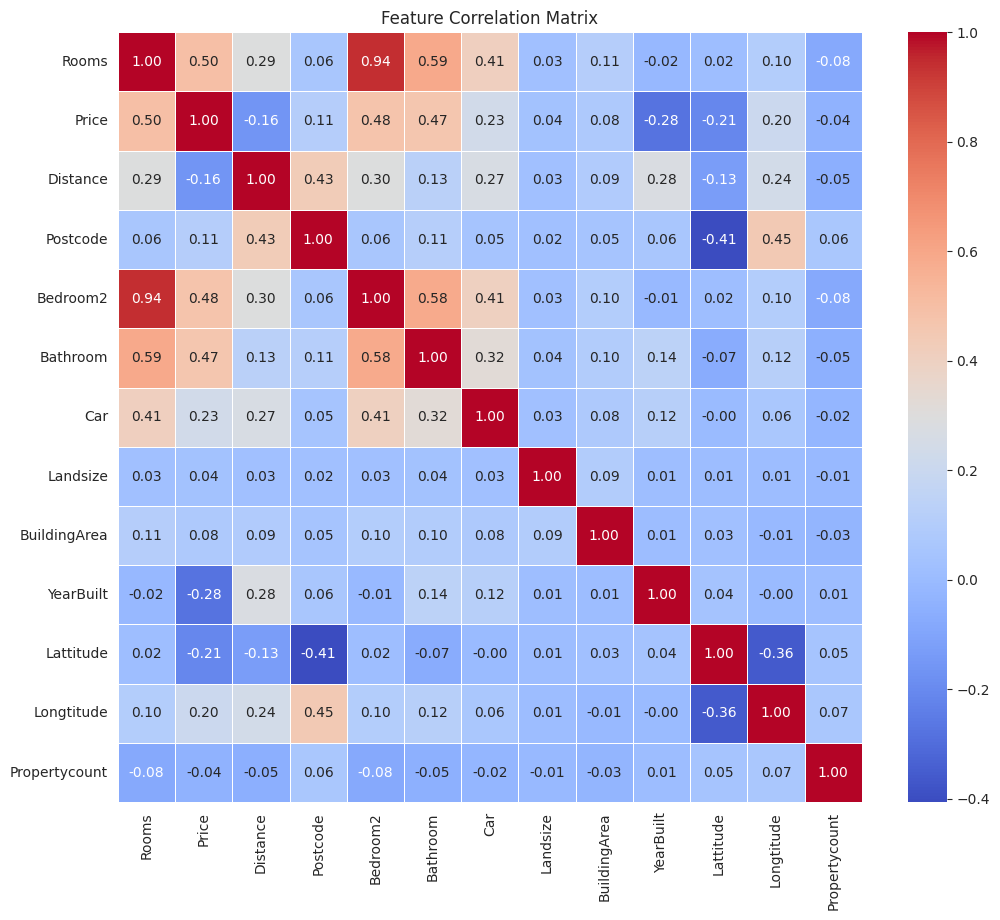

Price            1.000000
Rooms            0.496634
Bedroom2         0.475951
Bathroom         0.467038
Car              0.234825
Longtitude       0.203656
Postcode         0.107867
BuildingArea     0.078828
Landsize         0.037507
Propertycount   -0.042153
Distance        -0.162522
Lattitude       -0.212934
YearBuilt       -0.278789
Name: Price, dtype: float64


In [54]:
plt.figure(figsize=(12, 10))

# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

# Compute and Plot Correlation
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Show Top Predictors
print(numeric_cols.corr()['Price'].sort_values(ascending=False))

**Insights from Correlation Matrix:**

* **Top Positive Drivers:** The strongest predictors of Price are **`Rooms` (0.50)** and **`Bathroom` (0.47)**. Effectively, the number of rooms and bathrooms dictates the value more than the raw surface area in this dataset.
* **The "Age" Factor:** **`YearBuilt` (-0.28)** has the strongest negative correlation. This indicates that **older houses tend to be more expensive** in Melbourne (likely due to historical value and better locations of older suburbs) compared to newer builds.
* **Location Matters:** **`Lattitude` (-0.21)** and **`Distance` (-0.16)** show that being closer to the CBD (lower distance) and further South (lower latitude) increases the price.
* **Surprising Weakness:** **`BuildingArea` (0.08)** and **`Landsize` (0.04)** show very weak correlation. This might be due to the data imputation strategy (using medians) or the fact that in Melbourne, the *location* (land value) outweighs the *size* of the structure.
* **Confirmed Redundancy:** The correlation between **`Rooms`** and **`Bedroom2`** is **0.94**. This confirms they are practically identical, and `Bedroom2` can be safely dropped to avoid multicollinearity.

## Geospatial Analysis
Real estate is heavily dependent on location. Since we have geographical coordinates (`Lattitude` and `Longtitude`), we can visualize the distribution of prices across Melbourne.

**Objective:**
* Identify "hotspots" (areas with the highest property prices).
* Visualize the relationship between location and price (e.g., proximity to the coast or city center).

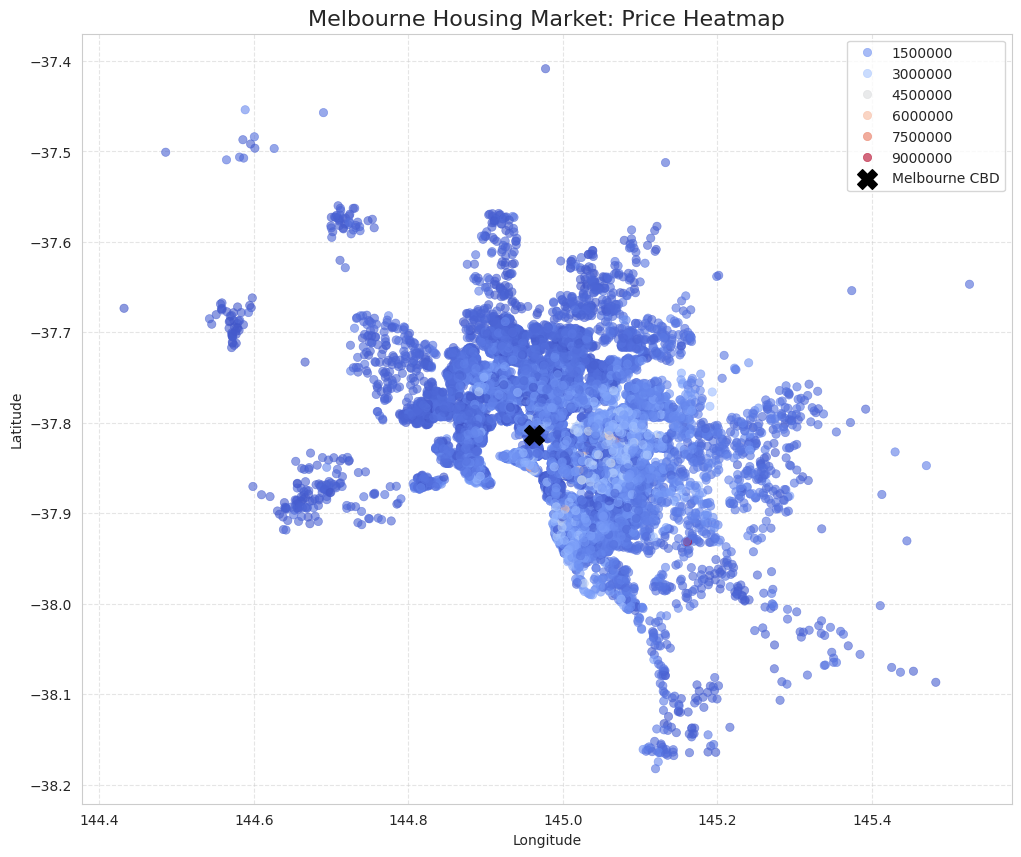

In [55]:
plt.figure(figsize=(12, 10))

# Create a scatterplot using Latitude and Longitude
sns.scatterplot(x='Longtitude', y='Lattitude', hue='Price', 
                data=df, palette='coolwarm', alpha=0.6, edgecolor=None)

plt.title('Melbourne Housing Market: Price Heatmap', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Price (AUD)')
plt.grid(True, linestyle='--', alpha=0.5)

# Add a marker for the City Center (CBD) for reference
# Melbourne CBD coords: -37.8136, 144.9631
plt.scatter(144.9631, -37.8136, color='black', marker='X', s=200, label='Melbourne CBD')
plt.legend()

plt.show()

**Geospatial Insights:**

* **The "Wealth Corridor":** The map reveals a distinct concentration of high-value properties (lighter blue to reddish dots) located immediately **South and South-East** of the CBD (marked with the black 'X') and following the coastline. This area corresponds to Melbourne's traditional prestigious suburbs.
* **Affordability in the West/North:** The vast majority of the map, particularly to the West and North of the CBD, is dominated by dark blue dots. This indicates that properties in these areas are significantly more affordable and fall into the lower price brackets.
* **Price Skew Visible:** The scarcity of "Red" (extremely expensive) points compared to the "Blue" sea visually confirms our earlier finding: the market is right-skewed, with a few luxury properties pushing the maximum price up, while most inventory remains in the lower-to-mid range.

## Categorical Variables vs Price
Finally, we analyze how categorical variables influence the price. We use **Boxplots** to visualize the distribution of prices across different categories.

**What to look for:**
* **Median differences:** The line inside the box represents the median price.
* **Spread:** The height of the box shows the variability of prices in that category.
* **Outliers:** The dots outside the "whiskers" represent extreme values.

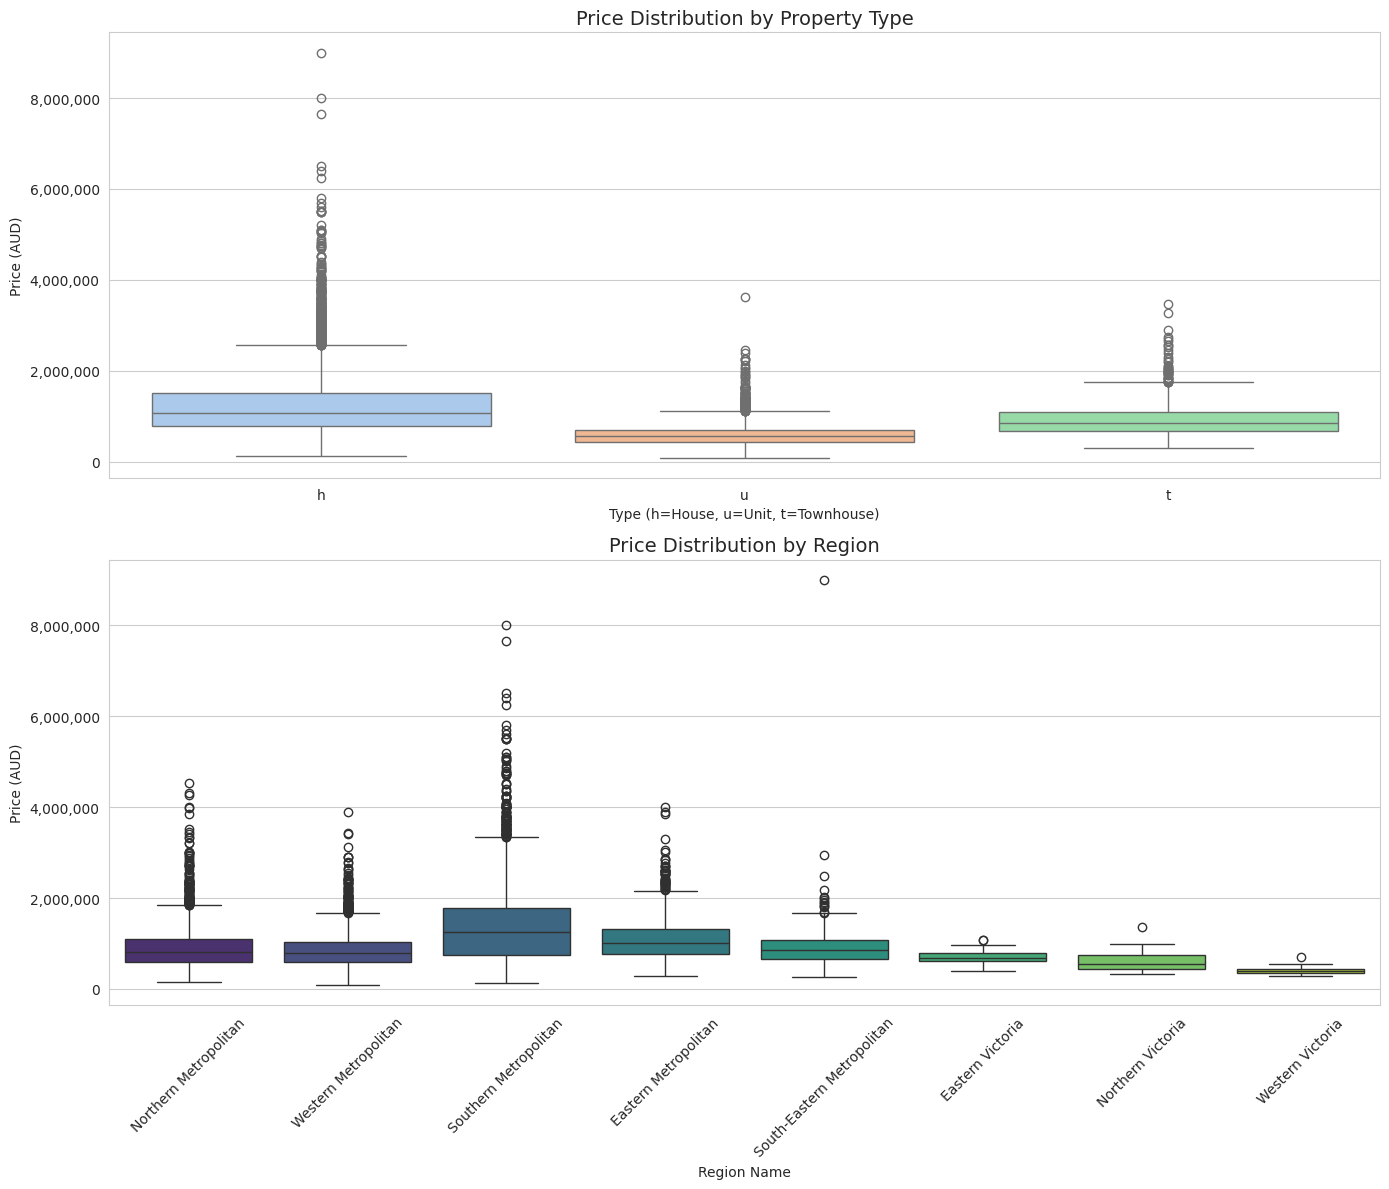

In [56]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Price vs Type
# Boxplots are ideal here to compare the spread and median prices across categories
sns.boxplot(x='Type', y='Price', hue='Type', data=df, palette='pastel', legend=False, ax=axes[0])

axes[0].set_title('Price Distribution by Property Type', fontsize=14)
axes[0].set_xlabel('Type (h=House, u=Unit, t=Townhouse)')
axes[0].set_ylabel('Price (AUD)')

axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


# Price vs Region
# This verifies the "Location" factor. We expect significant variance between regions.
sns.boxplot(x='Regionname', y='Price', hue='Regionname', data=df, palette='viridis', legend=False, ax=axes[1])

axes[1].set_title('Price Distribution by Region', fontsize=14)
axes[1].set_xlabel('Region Name')
axes[1].set_ylabel('Price (AUD)')
axes[1].tick_params(axis='x', rotation=45) # Rotate labels to avoid overlap
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.tight_layout()
plt.show()

**Categorical Insights (Boxplots):**

* **The "Land" Premium (Type):** The top plot confirms a distinct price hierarchy. **Houses (`h`)** have a significantly higher median price and a much wider spread (taller box) compared to Units (`u`) and Townhouses (`t`). This confirms that the land component (typical of houses) is the primary driver of value, whereas units are more standardized in price.
* **The "Prestige" Factor (Region):** The bottom plot illustrates clear economic zones:
    * **Southern Metropolitan** is the clear market leader, showing the highest median price and the most extreme outliers (luxury estates reaching $8M+).
    * **Eastern Metropolitan** follows as the second most expensive tier.
    * **Regional/Rural Areas:** The "Victoria" regions (Eastern, Northern, Western Victoria) have very low medians and almost no variance, indicating a consistently affordable market compared to the city center.

## Conclusion

This Exploratory Data Analysis (EDA) has provided the blueprint for our predictive model. Here are the critical takeaways that will shape our training pipeline in `train.py`:

### 1. Data Strategy
* **Missing Values:** We successfully handled gaps in `BuildingArea` and `YearBuilt` using neighborhood-specific medians. For `Car`, we assumed missing values equal 0 spots. This logic must be replicated in our transformation pipeline.
* **Target Variable:** The `Price` column is **right-skewed**. To improve model performance (especially for linear models), we should consider applying a **Log Transformation** to the price during training.

### 2. Feature Selection Insights
* **Top Drivers:** The strongest positive predictors of price are **`Rooms`** (0.50 correlation) and **`Bathroom`** (0.47).
* **The "Size" Surprise:** Contrary to expectations, **`BuildingArea` (0.08)** and **`Landsize` (0.03)** showed very weak correlation with Price in this specific dataset.
* **The "Age" Paradox:** `YearBuilt` has a negative correlation (-0.28), meaning **older** houses in Melbourne often command higher prices (likely due to location and historical value).
* **Redundancy:** The feature `Bedroom2` is almost identical to `Rooms` (correlation > 0.90). We will **drop `Bedroom2`** to avoid multicollinearity.

### 3. Location & Structure
* **Geography:** The "Southern Metropolitan" region and proximity to the CBD (`Distance`) are heavily correlated with higher prices.
* **Property Type:** Houses (`h`) are a distinct market segment from Units (`u`) and Townhouses (`t`), with significantly higher variance.